In [ ]:
from tensorflow.keras.layers import (Input, Dense, Conv2D, BatchNormalization, ReLU, Add, GlobalAveragePooling2D)
from tensorflow.keras.utils import plot_model
from IPython.display import Image
import tensorflow as tf
from typing import Tuple
import numpy as np
from sklearn.model_selection import train_test_split
from temperature_scaling_tensorflow import TemperatureScaling, expected_calibration_error
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve
#changes

In [4]:
# Load the cifar10-Dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

# Reshape y_train to (50000, )
y_train = y_train.reshape(-1)

# Split the dataset 
x_train_new, x_val, y_train_new, y_val = train_test_split(
    x_train, y_train, test_size=0.2, random_state=42
)

(10000,)

In [5]:
# Load the pretrained model
model_logits = tf.keras.models.load_model("best_model_logits.keras")

# Evaluate the model
test_loss, test_acc = model_logits.evaluate(x_test, y_test)
print(f"test_loss: {test_loss}, test_acc: {test_acc}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 1.1314 - sparse_categorical_accuracy: 0.8028
test_loss: 1.1314232349395752, test_acc: 0.8027999997138977


In [6]:
tes1 = TemperatureScaling(model_logits)
tes1.set_temperature(x_val, y_val)
x_test_predicted = tes1.predict(x_test, True).numpy()

x_test_before = model_logits(x_test, training=False).numpy()
x_test_before = tf.nn.softmax(x_test_before, axis=-1).numpy()

Optimal Temperature: 3.363
Check Optimal Temperature: 3.363


In [82]:
ece_before = expected_calibration_error(x_test_before, y_test.flatten())
ece_after = expected_calibration_error(x_test_predicted, y_test.flatten())
print(f"ECE before calibration: {ece_before:.3f}")
print(f"ECE after calibration : {ece_after:.3f}")

ECE before calibration: 0.141
ECE after calibration : 0.007


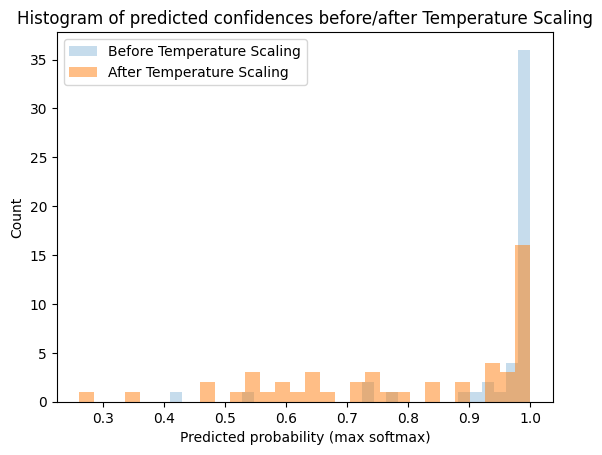

In [84]:
def plot_reliability(
    y_true: np.ndarray,
    probs: np.ndarray,
    probs_T: np.ndarray
) -> None:
    """
    Plot histograms of predicted confidences before and after Temperature Scaling.

    Args:
        y_true: True labels (array of shape [n_samples,]).
        probs: Predicted probabilities before Temperature Scaling (shape [n_samples, n_classes]).
        probs_T: Predicted probabilities after Temperature Scaling (shape [n_samples, n_classes]).
    """
    # predicted class probabilities BEFORE TS
    pred_before = np.max(probs, axis=1)

    # predicted class probabilities AFTER TS
    pred_after = np.max(probs_T, axis=1)

    plt.hist(pred_before, bins=30, alpha=0.25, label='Before Temperature Scaling')
    plt.hist(pred_after, bins=30, alpha=0.5, label='After Temperature Scaling')
    plt.xlabel("Predicted probability (max softmax)")
    plt.ylabel("Count")
    plt.title("Histogram of predicted confidences before/after Temperature Scaling")
    plt.legend()
    plt.show()

probs_true = x_test_before[np.arange(len(y_test_flattened)), y_test_flattened]
probs_T_true = x_test_predicted[np.arange(len(y_test_flattened)), y_test_flattened]

plot_reliability(y_test_flattened, x_test_before[:50], x_test_predicted[:50])